# Problem statement, Data dictionary

Each sample is composed of data from 25 cells, covering an area of 625 m2. Each cell represents an area of 5 x 5 m2 and has nine features (as introduced in section 2). For a landslide sample, cell 13 is the location of landslide, and other cells are the neighboring areas. For a non-landslide sample, there is no recorded landslide occurrence within the sample area.

- CELLID_elevation	Continuous	
Digital elevation of the terrain surface in meter

- CELLID_slope	Continuous	
Angle of the slope inclination in degree

- CELLID_aspect	Continuous	
Exposition of the slope in degree
(direction of the slope?) -> dummied to 8 NSEW

- CELLID_placurv	Continuous	
Planform curvature, curvature perpendicular to the direction of the maximum slope

- CELLID_procurv	Continuous	
Profile curvature, curvature parallel to the slope, indicating the direction of maximum slope

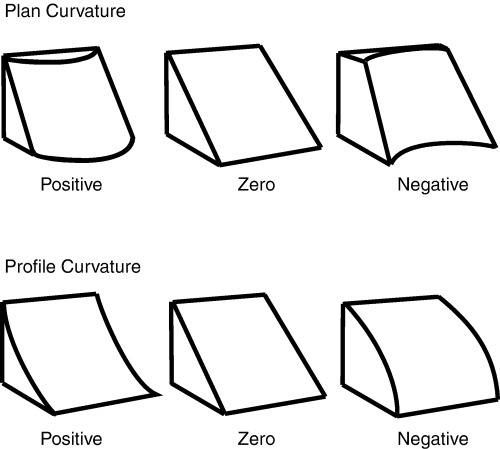


- CELLID_lsfactor	Continuous	
Length-slope factor that accounts for the effects of topography on erosion

- CELLID_twi	Continuous	
Topographic wetness index, an index to quantify the topographic control on hydrological process

- CELLID_geology	Categorical	Lithology of the surface material
1: Weathered Cretaceous granitic rocks
2: Weathered Jurassic granite rocks
3: Weathered Jurassic tuff and lava
4: Weathered Cretaceous tuff and lava
5: Quaternary deposits
6: Fill
7: Weathered Jurassic sandstone, siltstone and mudstone

- CELLID_sdoif	Continuous	
Step duration orographic intensification factor: an index to quantify the amplification of orography on rainfall


# 0. Import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# all columns, limit 200 rows
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", 200)

# round up DISPLAY 4 decimal
pd.options.display.float_format = "{:,.4f}".format

import time

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.feature_selection import RFE



from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# !conda install -c conda-forge py-xgboost 
# !pip install xgboost
import xgboost as xgb

from sklearn.metrics import ( 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    plot_confusion_matrix, 
    classification_report, 
    precision_recall_curve,
    make_scorer,
 
) 

C:\Users\nguye_5159g\anaconda3\envs\newbase010323\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
# Weight of evidence: categorical
def convert_woe_cat(feature, target='Label'):
   
    # woe calculation
    df_woe = df.groupby(feature).count()[[target]]
    df_woe.columns=['Total']
    df_woe['Good'] = df.groupby(feature).sum(numeric_only =True)[target]
    df_woe['Bad'] = df_woe.Total - df_woe.Good

    good = df_woe.Good
    bad  = df_woe.Bad
    total_good = df_woe.Good.sum()
    total_bad  = df_woe.Bad.sum()
    df_woe['WOE'] = np.log(good/total_good + 0.001) - np.log(bad/total_bad + 0.001)
    df_woe['IV'] = df_woe.WOE*(good/total_good - bad/total_bad)
    print(f'Information value: {df_woe.IV.sum():.2f}')
    return df_woe.sort_values('WOE', ascending=False)

In [7]:
# Weight of evidence
def convert_woe(feature, bins=10, target='Label'):
    # set label length if bins input is list (in case of coarse finetuning)
    label_length=0
    if isinstance(bins,list):
        label_length = len(bins)
    else:
        label_length = bins+1
    # bins, range and target count    
    df_bins = pd.DataFrame({
        feature+'_bins': pd.cut(df[feature], bins, labels=np.arange(1, label_length,1)).astype(int),
        feature+'_range': pd.cut(df[feature], bins),
        target : df[target]
    })
    # woe calculation
    df_woe = df_bins.groupby(feature+'_range').agg(pd.Series.mode)[[feature+'_bins']]
    df_woe.columns=['Bin']
    df_woe['Total'] = df_bins.groupby(feature+'_range').count()[[target]]
    df_woe['Good'] = df_bins.groupby(feature+'_range').sum(numeric_only =True)[target]
    df_woe['Bad'] = df_woe.Total - df_woe.Good

    good = df_woe.Good
    bad  = df_woe.Bad
    total_good = df_woe.Good.sum()
    total_bad  = df_woe.Bad.sum()
    df_woe['WOE'] = np.log(good/total_good + 0.001) - np.log(bad/total_bad + 0.001)
    df_woe['IV'] = df_woe.WOE*(good/total_good - bad/total_bad)
    print(f'Information value: {df_woe.IV.sum():.2f}')
    return df_woe.sort_values('WOE', ascending=False)

In [8]:
# Weight of evidence (sliced)
def convert_woe_sliced(feature, sliced_location, bins=10, target='Label'):
    # set label length if bins input is list (in case of coarse finetuning)
    label_length=0
    if isinstance(bins,list):
        label_length = len(bins)
    else:
        label_length = bins+1
        
    df_bins = pd.DataFrame({
        feature+'_bins': pd.cut(df[feature][sliced_location], bins, labels=np.arange(1, label_length,1)).astype(int),
        feature+'_range': pd.cut(df[feature][sliced_location], bins),
        target : df[target][sliced_location]
    })
    df_woe = df_bins.groupby(feature+'_range').agg(pd.Series.mode)[[feature+'_bins']]
    df_woe.columns=['Bin']
    df_woe['Total'] = df_bins.groupby(feature+'_range').count()[[target]]
    df_woe['Good'] = df_bins.groupby(feature+'_range').sum(numeric_only =True)[target]
    df_woe['Bad'] = df_woe.Total - df_woe.Good

    good = df_woe.Good
    bad  = df_woe.Bad
    total_good = df_woe.Good.sum()
    total_bad  = df_woe.Bad.sum()
    df_woe['WOE'] = np.log(good/total_good + 0.001) - np.log(bad/total_bad + 0.001)
    df_woe['IV'] = df_woe.WOE*(good/total_good - bad/total_bad)
    print(f'Information value: {df_woe.IV.sum():.2f}')
    return df_woe.sort_values('WOE', ascending=False)

# 1. Data preprocessing

In [3]:
df = pd.read_csv('landslide_engineered_features.csv')
df.head()

,Label,aspect_NSEW,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center
0,0,SE,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,++-,0.0214,+--,0.0668,19.2870,3.1545,3.4665,3,3,1.2817
1,1,S,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,+++,-0.0193,---,0.0055,16.6390,4.3839,4.6605,3,3,1.3596
2,0,W,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,+++,-0.0274,+++,0.0026,28.8700,4.1693,4.2278,2,2,1.3651
3,0,S,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,+++,-0.0229,+-+,0.0146,8.2114,4.2599,3.7378,2,2,1.1008
4,0,SE,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,---,0.0181,---,0.0205,15.8179,4.4302,4.5421,2,5,1.2842


In [4]:
# Dummy
to_dummies = ['aspect_NSEW']
aspect_NSEW_dummies = pd.get_dummies(df[to_dummies], drop_first=True)
aspect_NSEW_dummies.columns = [x.replace('_NSEW','') for x in aspect_NSEW_dummies.columns]
df = pd.concat([df, aspect_NSEW_dummies], axis=1)

df.drop(columns='aspect_NSEW', inplace=True)

In [9]:
# convert to woe
temp = pd.read_csv('df\Train.csv')
placurv_cols = temp.columns[1+25*3:26+25*3].tolist()
procurv_cols = temp.columns[1+25*4:26+25*4].tolist()

df = pd.concat([df, temp[placurv_cols]], axis=1)
df.placurv_signs_8 = df.placurv_signs_8.map(convert_woe_cat('placurv_signs_8')['WOE'])

df = pd.concat([df, temp[procurv_cols]], axis=1)
df.procurv_signs_8 = df.procurv_signs_8.map(convert_woe_cat('procurv_signs_8')['WOE'])

df.drop(columns=placurv_cols+procurv_cols, inplace=True)

Information value: 0.13
Information value: 0.11


In [11]:
df.head()

,Label,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center,aspect_N,aspect_NE,aspect_NW,aspect_S,aspect_SE,aspect_SW,aspect_W
0,0,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,0.1635,0.0214,0.3706,0.0668,19.2870,3.1545,3.4665,3,3,1.2817,0,0,0,0,1,0,0
1,1,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,-0.4845,-0.0193,0.1837,0.0055,16.6390,4.3839,4.6605,3,3,1.3596,0,0,0,1,0,0,0
2,0,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,-0.4845,-0.0274,-0.4567,0.0026,28.8700,4.1693,4.2278,2,2,1.3651,0,0,0,0,0,0,1
3,0,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,-0.4845,-0.0229,-0.3943,0.0146,8.2114,4.2599,3.7378,2,2,1.1008,0,0,0,1,0,0,0
4,0,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,0.1881,0.0181,0.1837,0.0205,15.8179,4.4302,4.5421,2,5,1.2842,0,0,0,0,1,0,0


## Train/test, scale

In [14]:
X = df.drop(columns='Label')
Y = df.Label

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.1, random_state=14)

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), index = X_test.index, columns = X_test.columns)

# 2. Base model

## Confusion matrix

In [15]:
def cf_percent(y_actual, y_pred, heatmap_labels, ax):
    cf = confusion_matrix(y_actual, y_pred) 
    # group_labels = ['TN\n', 'FP\n', 'FN\n', 'TP\n']
    group_labels = [' ']*4
    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()] 
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)] 
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)] 
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1]) 
    sns.heatmap(cf, annot=box_labels, fmt="", xticklabels=heatmap_labels, yticklabels=heatmap_labels, ax=ax, cbar=False) 

In [16]:
def cf_train_test(y_train_actual, y_train_predicted, y_test_actual, y_test_predicted): 
    
    fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(8,4))
    heatmap_labels = ['Non LS', 'Landslide']
    
    cf_percent(y_train_actual, y_train_predicted, heatmap_labels, ax=ax1)
    cf_percent(y_test_actual, y_test_predicted, heatmap_labels, ax=ax2)
    
    ax1.set(ylabel='Actual', xlabel='Predicted', title='Train') 
    ax2.set(ylabel='Actual', xlabel='Predicted', title='Test')
    plt.show()

## Feature importance 

In [17]:
def feature_importance_tree(models_list, limit=25):
    ncols = len(models_list)
    fig, ax = plt.subplots(ncols=ncols, sharex=False, sharey=False, figsize=(4*ncols,8))  
    if ncols == 1:
        ax=[ax]
    for (model, model_name),ax in zip(models_list,ax):
        ax.set_title(model_name)
        importance_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, 
                                     columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
        importance_df = importance_df.head(limit)
        sns.barplot(x = importance_df['Importance'], y = importance_df.index, ax=ax)
        ax.set_yticks([])
        
        for index,y in zip(importance_df.index, np.arange(0.25, len(importance_df.index),1)):
            ax.annotate(index, xy=(0.005,y))
    plt.show()

## Base model

In [18]:
class_weights = {0: .25, 1: .75}

DTree_base = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=3, class_weight= class_weights, random_state = 14)
RF_base = RandomForestClassifier(max_depth=10,min_samples_split=10, min_samples_leaf=3, class_weight= class_weights,  random_state = 14)

LG_base = LogisticRegression(max_iter = 500, class_weight= class_weights, random_state = 14)


SVM_linear = SVC(kernel='linear', random_state = 14, probability=True)
SVM_rbf = SVC(kernel='rbf', random_state = 14, probability=True)
KNN_base = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
KNN_weight = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
KNN_weight9 = KNeighborsClassifier(n_neighbors=9, weights = 'distance')


ADA_base = AdaBoostClassifier(random_state = 14)
GB_base = GradientBoostingClassifier(random_state = 14)
XGB_base = xgb.XGBClassifier(objective='binary:logistic', seed=14, use_label_encoder=False)
XGB_9 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, reg_lambda= 0.0, max_depth= 9, learning_rate= 0.1, gamma= 0.00, seed=14, use_label_encoder=False)

regression_models = [
    (LG_base, 'LG_base')
]

tree_models = [
    (DTree_base,'DTree_base'),
    (RF_base, 'RF_base'),
]


distance_models = [
    (SVM_linear,'SVM_linear'),
    (SVM_rbf,'SVM_rbf'),
    (KNN_base,'KNN_base'),
    (KNN_weight,'KNN_weight'),
    (KNN_weight9,'KNN_weight9')
]

boosting_models = [
    (ADA_base,'ADA_base'),
    (GB_base,'GB_base'),
    (XGB_base,'XGB_base'),
    (XGB_9,'XGB_9')
]


### Tree model

DTree_base ______________________________________________________________________ Time: 0.11
Train
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      7333
           1       0.59      0.95      0.73      2444

    accuracy                           0.82      9777
   macro avg       0.79      0.87      0.80      9777
weighted avg       0.88      0.82      0.83      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       815
           1       0.51      0.80      0.62       272

    accuracy                           0.76      1087
   macro avg       0.71      0.77      0.72      1087
weighted avg       0.82      0.76      0.77      1087



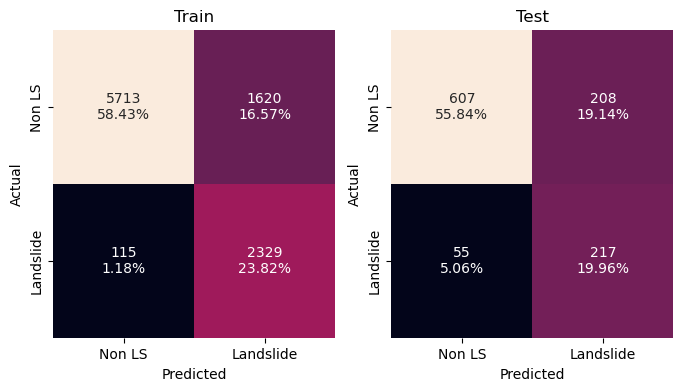

******************************************************************************************
RF_base _________________________________________________________________________ Time: 1.18
Train
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      7333
           1       0.67      0.91      0.77      2444

    accuracy                           0.87      9777
   macro avg       0.82      0.88      0.84      9777
weighted avg       0.89      0.87      0.87      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       815
           1       0.60      0.78      0.68       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.84      0.82      0.82      1087



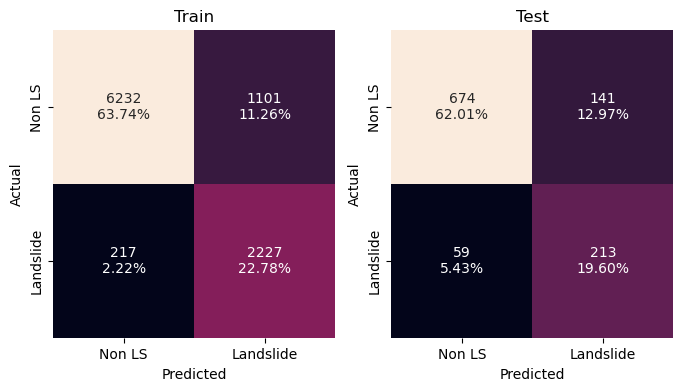

******************************************************************************************


In [19]:
for model, model_name in tree_models:
    start = time.time()
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)
    time_complete = time.time() - start
    
    spacing = '_'*(80-len(model_name))
    print(f'{model_name} {spacing} Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

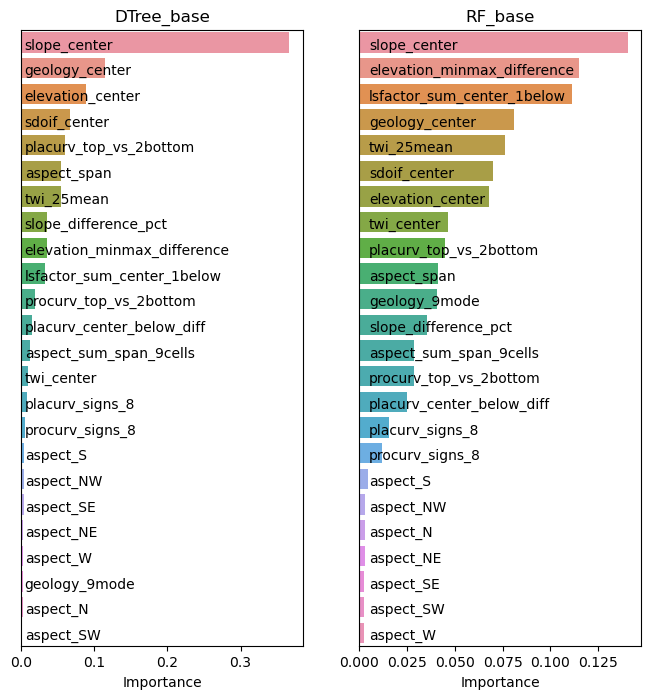

In [20]:
feature_importance_tree(tree_models)

### Regression models

LG_base _________________________________________________________________________ Time: 0.05
Train
              precision    recall  f1-score   support

           0       0.92      0.75      0.82      7333
           1       0.52      0.81      0.63      2444

    accuracy                           0.76      9777
   macro avg       0.72      0.78      0.73      9777
weighted avg       0.82      0.76      0.78      9777

Test
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       815
           1       0.57      0.75      0.65       272

    accuracy                           0.80      1087
   macro avg       0.74      0.78      0.75      1087
weighted avg       0.82      0.80      0.81      1087



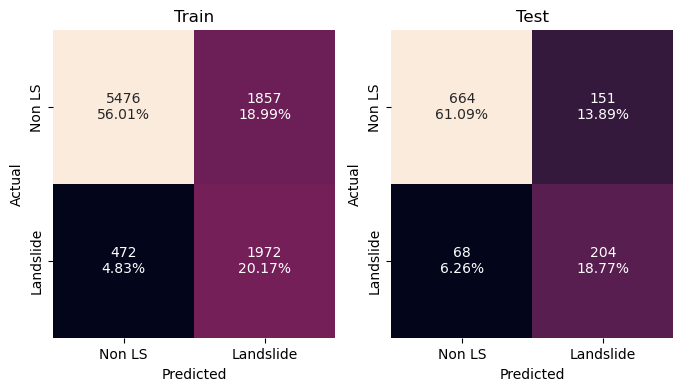

******************************************************************************************


In [21]:
for model, model_name in regression_models:
    start = time.time()
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test  = model.predict(X_test_scaled)
    time_complete = time.time() - start
    
    spacing = '_'*(80-len(model_name))
    print(f'{model_name} {spacing} Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

In [22]:
# feature importance for logistic regression models
for model, model_name in regression_models:
    feature_importance = pd.DataFrame(
        {'feature': X_train_scaled.columns,
        'coef': abs(model.coef_[0])}
    )

    print(f'{model_name}')
    print(feature_importance.sort_values('coef', ascending=False).head(15))
    print('*'*50)

LG_base
                        feature   coef
13                   twi_25mean 5.0208
2                  slope_center 4.6120
0              elevation_center 2.3159
14               geology_center 2.3125
16                 sdoif_center 2.2749
8        placurv_top_vs_2bottom 1.8745
11   lsfactor_sum_center_1below 1.8179
10       procurv_top_vs_2bottom 1.1850
7               placurv_signs_8 1.0439
6     placurv_center_below_diff 0.7132
3          slope_difference_pct 0.6148
5        aspect_sum_span_9cells 0.5934
1   elevation_minmax_difference 0.5271
20                     aspect_S 0.4619
18                    aspect_NE 0.4080
**************************************************


### **Distance models**

SVM_linear ______________________________________________________________________ Time: 10.31
Train
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      7333
           1       0.68      0.46      0.55      2444

    accuracy                           0.81      9777
   macro avg       0.76      0.70      0.72      9777
weighted avg       0.80      0.81      0.80      9777

Test
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       815
           1       0.77      0.27      0.40       272

    accuracy                           0.80      1087
   macro avg       0.78      0.62      0.64      1087
weighted avg       0.79      0.80      0.76      1087



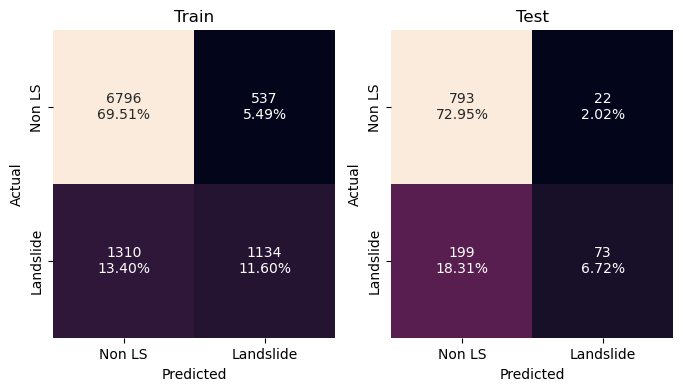

******************************************************************************************
SVM_rbf _________________________________________________________________________ Time: 17.97
Train
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7333
           1       0.72      0.48      0.57      2444

    accuracy                           0.82      9777
   macro avg       0.78      0.71      0.73      9777
weighted avg       0.81      0.82      0.81      9777

Test
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       815
           1       0.76      0.30      0.43       272

    accuracy                           0.80      1087
   macro avg       0.78      0.63      0.65      1087
weighted avg       0.79      0.80      0.77      1087



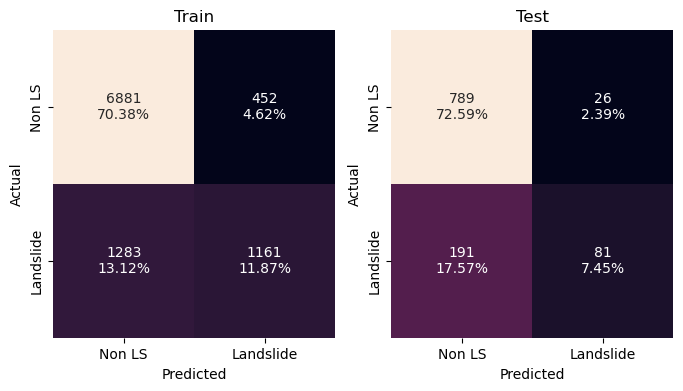

******************************************************************************************
KNN_base ________________________________________________________________________ Time: 0.51
Train
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7333
           1       0.75      0.69      0.72      2444

    accuracy                           0.86      9777
   macro avg       0.82      0.81      0.81      9777
weighted avg       0.86      0.86      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       815
           1       0.61      0.43      0.50       272

    accuracy                           0.79      1087
   macro avg       0.72      0.67      0.68      1087
weighted avg       0.77      0.79      0.78      1087



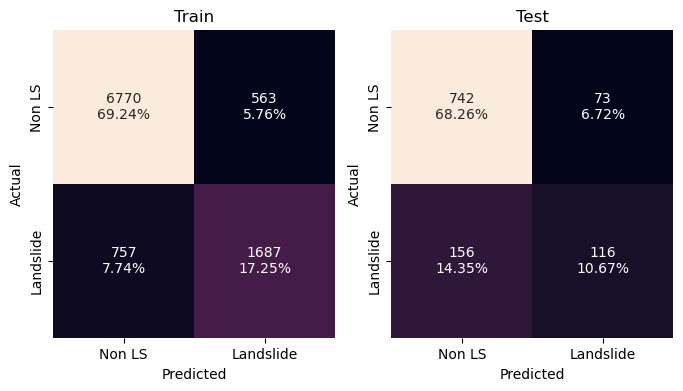

******************************************************************************************
KNN_weight ______________________________________________________________________ Time: 0.18
Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7333
           1       1.00      1.00      1.00      2444

    accuracy                           1.00      9777
   macro avg       1.00      1.00      1.00      9777
weighted avg       1.00      1.00      1.00      9777

Test
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       815
           1       0.62      0.43      0.51       272

    accuracy                           0.79      1087
   macro avg       0.72      0.67      0.69      1087
weighted avg       0.77      0.79      0.78      1087



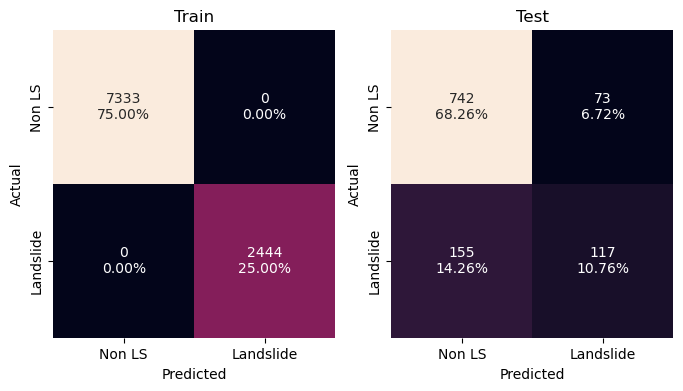

******************************************************************************************
KNN_weight9 _____________________________________________________________________ Time: 0.19
Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7333
           1       1.00      1.00      1.00      2444

    accuracy                           1.00      9777
   macro avg       1.00      1.00      1.00      9777
weighted avg       1.00      1.00      1.00      9777

Test
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       815
           1       0.66      0.46      0.54       272

    accuracy                           0.81      1087
   macro avg       0.75      0.69      0.71      1087
weighted avg       0.79      0.81      0.79      1087



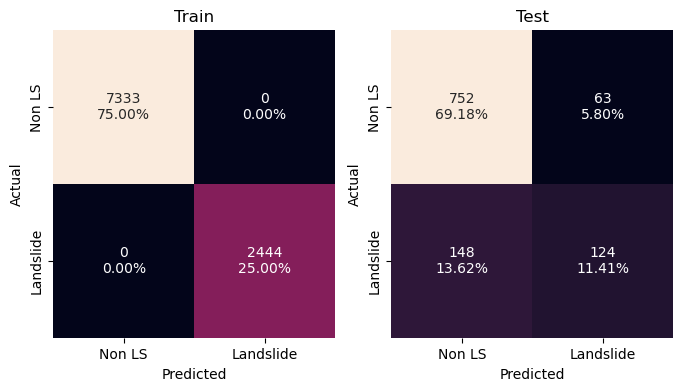

******************************************************************************************


In [23]:
for model, model_name in distance_models:
    start = time.time()
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test  = model.predict(X_test_scaled)
    time_complete = time.time() - start
    
    spacing = '_'*(80-len(model_name))
    print(f'{model_name} {spacing} Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

### Gradient boosting models

ADA_base ________________________________________________________________________ Time: 0.75
Train
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7333
           1       0.69      0.59      0.64      2444

    accuracy                           0.83      9777
   macro avg       0.78      0.75      0.76      9777
weighted avg       0.83      0.83      0.83      9777

Test
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       815
           1       0.68      0.55      0.61       272

    accuracy                           0.82      1087
   macro avg       0.77      0.73      0.75      1087
weighted avg       0.81      0.82      0.82      1087



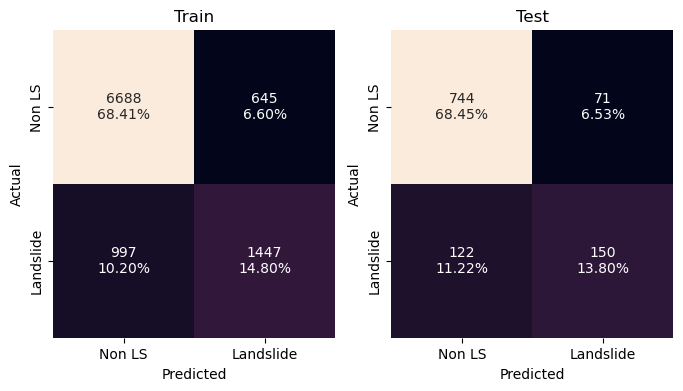

******************************************************************************************
GB_base _________________________________________________________________________ Time: 2.87
Train
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7333
           1       0.77      0.61      0.68      2444

    accuracy                           0.86      9777
   macro avg       0.83      0.78      0.80      9777
weighted avg       0.85      0.86      0.85      9777

Test
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       815
           1       0.73      0.54      0.62       272

    accuracy                           0.83      1087
   macro avg       0.79      0.74      0.76      1087
weighted avg       0.83      0.83      0.83      1087



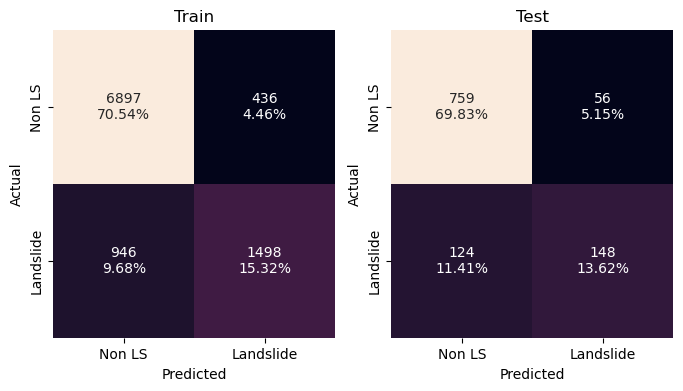

******************************************************************************************
[16:53:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nguye_5159g\anaconda3\envs\newbase010323\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGB_base ________________________________________________________________________ Time: 0.57
Train
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7333
           1       0.98      0.97      0.98      2444

    accuracy                           0.99      9777
   macro avg       0.99      0.98      0.99      9777
weighted avg       0.99      0.99      0.99      9777

Test
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       815
           1       0.74      0.60      0.66       272

    accuracy                           0.85      1087
   macro avg       0.81      0.77      0.78      1087
weighted avg       0.84      0.85      0.84      1087



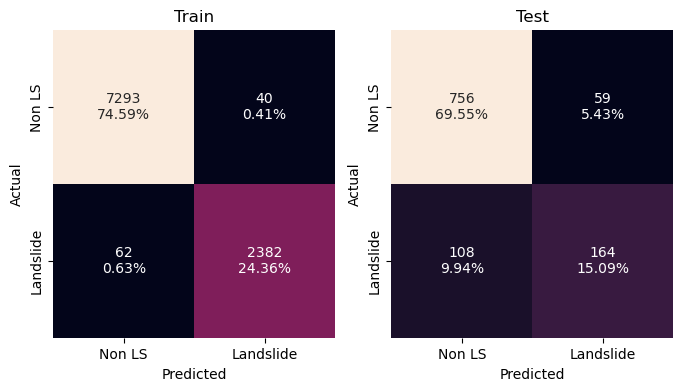

******************************************************************************************
[16:53:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nguye_5159g\anaconda3\envs\newbase010323\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGB_9 ___________________________________________________________________________ Time: 1.76
Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7333
           1       1.00      1.00      1.00      2444

    accuracy                           1.00      9777
   macro avg       1.00      1.00      1.00      9777
weighted avg       1.00      1.00      1.00      9777

Test
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       815
           1       0.77      0.62      0.69       272

    accuracy                           0.86      1087
   macro avg       0.82      0.78      0.80      1087
weighted avg       0.85      0.86      0.85      1087



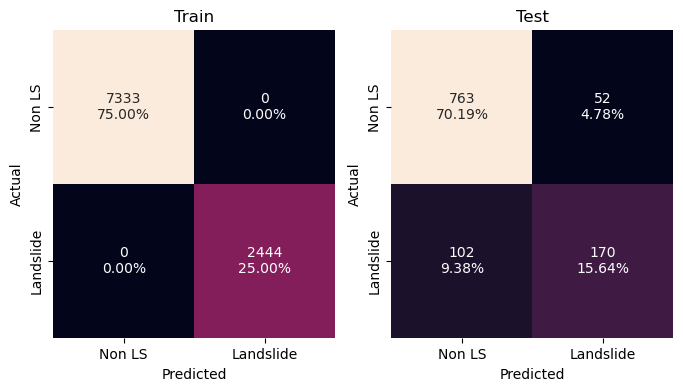

******************************************************************************************


In [24]:
# unscaled data
for model, model_name in boosting_models:
    start = time.time()
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)
    time_complete = time.time() - start
    
    spacing = '_'*(80-len(model_name))
    print(f'{model_name} {spacing} Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

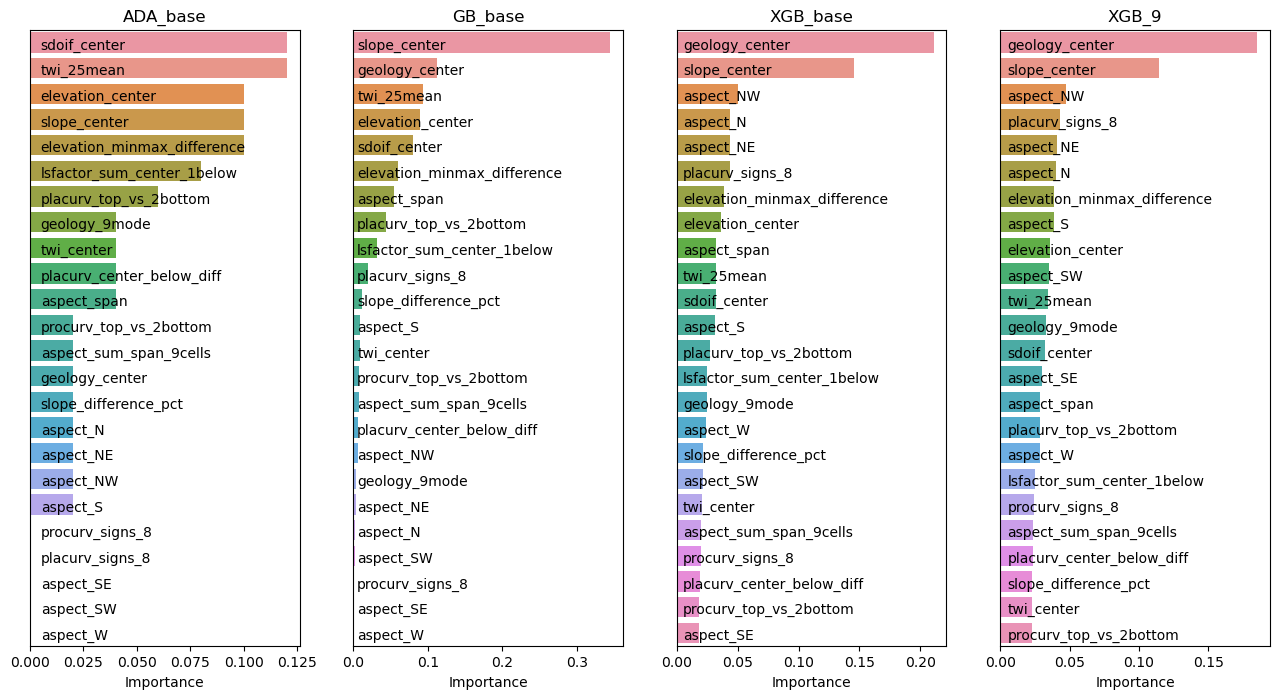

In [25]:
feature_importance_tree(boosting_models)

### AUC

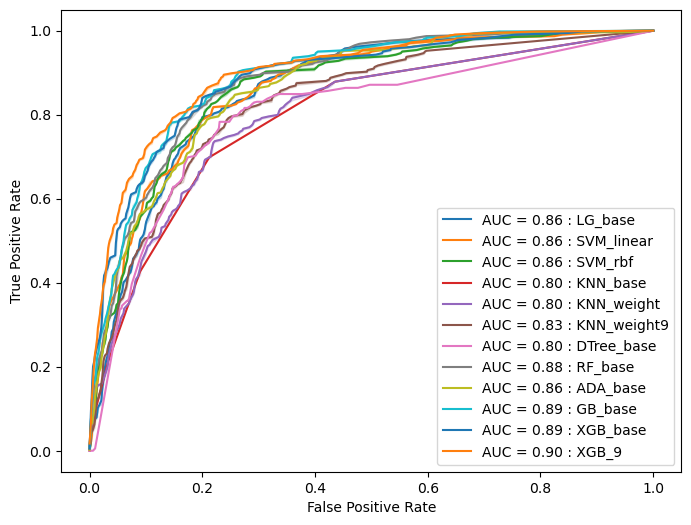

In [26]:
plt.figure(figsize=(8,6))

for model, model_name in regression_models+distance_models:
    yhat_proba = model.predict_proba(X_test_scaled)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score(y_test,  yhat_proba)
    space = ' ' * (20 - len(model_name))
    sns.lineplot(x=fpr,y=tpr, label=f'AUC = {auc_score:0.2f} : {model_name}')

    
    
for model, model_name in tree_models+boosting_models:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score(y_test,  yhat_proba)
    space = ' ' * (20 - len(model_name))
    sns.lineplot(x=fpr,y=tpr, label=f'AUC = {auc_score:0.2f} : {model_name}')
    
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()    

# 3. Logistic Regression

In [371]:
# add constant for statmodel
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

## Building model 1

### Feature selection

RFE can be used to select the best n features, but we have to decide how many n features we need. The code below will calculate with each n features, what is the highest VIF value among said n features to provide us a starting point.

In [374]:
def max_vif_n_features(features):
    '''
    features: list like, without 'const'
    '''
    max_vif_values = []
    model = LogisticRegression()
    X_data = X_train_scaled[['const'] + features]
    starting = 5

    # loop to calculate max VIF among n features
    for n_features in range(starting, X_data.iloc[:,1:].shape[1] + 1):
        rfe = RFE(model, n_features_to_select = n_features)
        rfe.fit(X_data.iloc[:,1:], y_train) 
        # top features selected
        top_n_features = rfe.get_feature_names_out(X_data.iloc[:,1:].columns).tolist()
        # calculate the highest vif values among the selected features
        vif_for_n_features = [vif(X_data[['const'] + top_n_features].values, i) for i in range(n_features+1)]
        max_vif_value = pd.Series(vif_for_n_features[1:]).max()
        max_vif_values = max_vif_values + [max_vif_value]
        if max_vif_value > 20:
            break

    df_result = pd.DataFrame({
        'n_features': range(starting, len(max_vif_values) + starting),
        'max_vif_value': max_vif_values
    })
    return df_result.sort_values('n_features', ascending=False)

In [430]:
model_lg1_features = X_train_scaled.columns[1:].tolist()

max_vif_n_features(model_lg1_features)

,n_features,max_vif_value
19,24,6.6530
18,23,6.6520
17,22,6.6511
16,21,6.6236
15,20,6.5869
14,19,6.5672
13,18,5.9012
12,17,5.8875
11,16,5.1866
10,15,5.1827


In [431]:
# Function to select n features using RFE
def rfe_top_features(features, n_features):
    X_data = X_train_scaled[['const'] + features]
    y_data = y_train
    
    model = LogisticRegression(max_iter=200)
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_data,y_data) 
    result = pd.DataFrame({'ranking': rfe.ranking_, 'features': X_data.columns}).sort_values('ranking')
    
    print(f'Top {n_features} features:')
    return rfe.get_feature_names_out().tolist()

In [476]:
model_lg1_top_features = rfe_top_features(model_lg1_features, 12)
model_lg1_top_features

Top 12 features:


['elevation_center',
 'elevation_minmax_difference',
 'slope_center',
 'placurv_center_below_diff',
 'placurv_signs_8',
 'placurv_top_vs_2bottom',
 'procurv_top_vs_2bottom',
 'lsfactor_sum_center_1below',
 'twi_center',
 'twi_25mean',
 'geology_center',
 'sdoif_center']

### Checking multicollinearity

In [433]:
def checking_vif(top_features):
    data = X_train_scaled[['const'] + top_features]
    result = pd.DataFrame()
    result['feature'] = data.columns

    # Calculating VIF for each feature
    result['VIF'] = [
        vif(data.values, i) for i in range(len(data.columns))
    ]
    result['VIF'] = result['VIF'].apply(lambda x: round(x,2))
    return result.sort_values('VIF', ascending=False)

In [477]:
checking_vif(model_lg1_top_features)

,feature,VIF
0,const,140.5900
3,slope_center,5.1500
6,placurv_top_vs_2bottom,3.9100
2,elevation_minmax_difference,3.8700
8,lsfactor_sum_center_1below,3.6500
10,twi_25mean,2.9700
9,twi_center,2.8700
4,placurv_center_below_diff,2.5300
5,placurv_signs_8,1.8500
7,procurv_top_vs_2bottom,1.4400


In [478]:
model_lg1_top_features.remove('slope_center')
checking_vif(model_lg1_top_features)

,feature,VIF
0,const,139.3700
5,placurv_top_vs_2bottom,3.9100
2,elevation_minmax_difference,3.0100
9,twi_25mean,2.9700
7,lsfactor_sum_center_1below,2.6600
3,placurv_center_below_diff,2.5200
8,twi_center,2.3600
4,placurv_signs_8,1.8500
6,procurv_top_vs_2bottom,1.3800
1,elevation_center,1.3300


<Axes: >

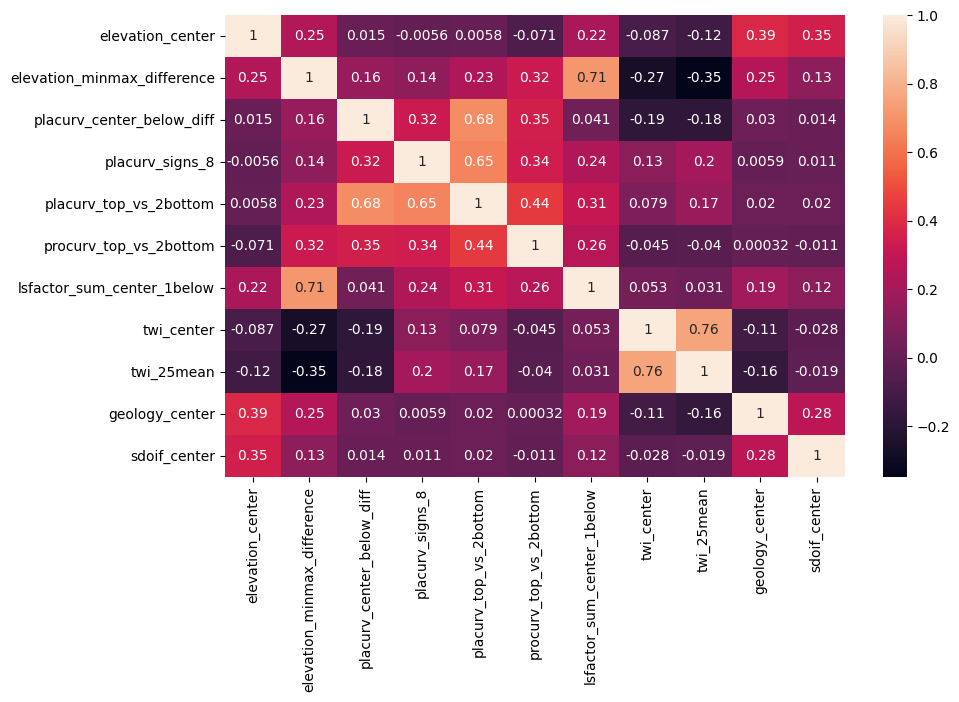

In [479]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled[model_lg1_top_features].corr(), annot=True)

<Axes: >

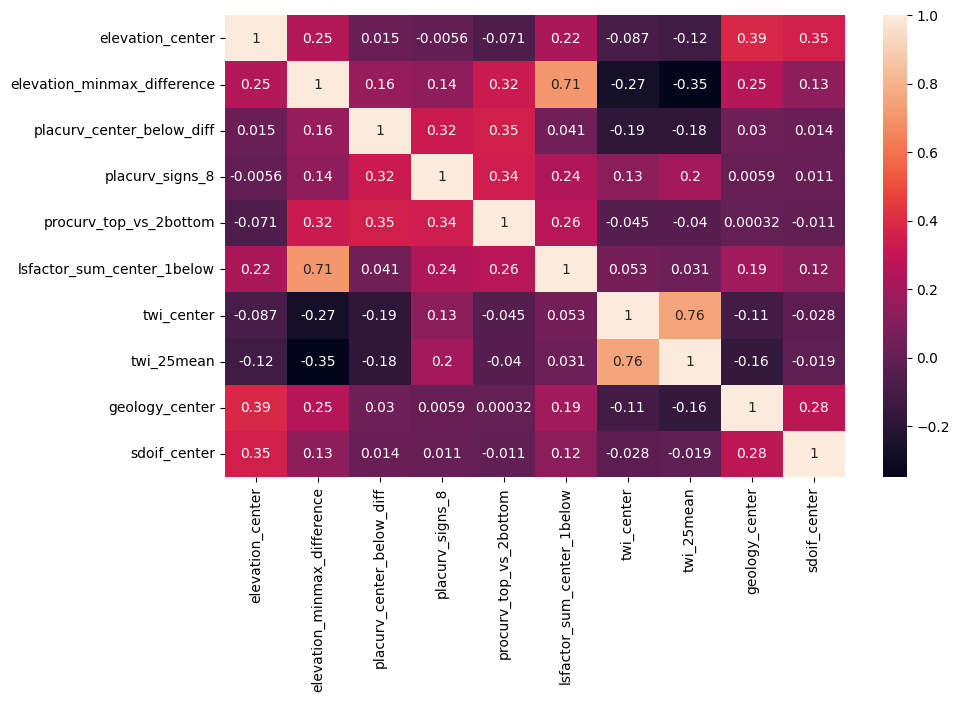

In [480]:
model_lg1_top_features.remove('placurv_top_vs_2bottom')
plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled[model_lg1_top_features].corr(), annot=True)

<Axes: >

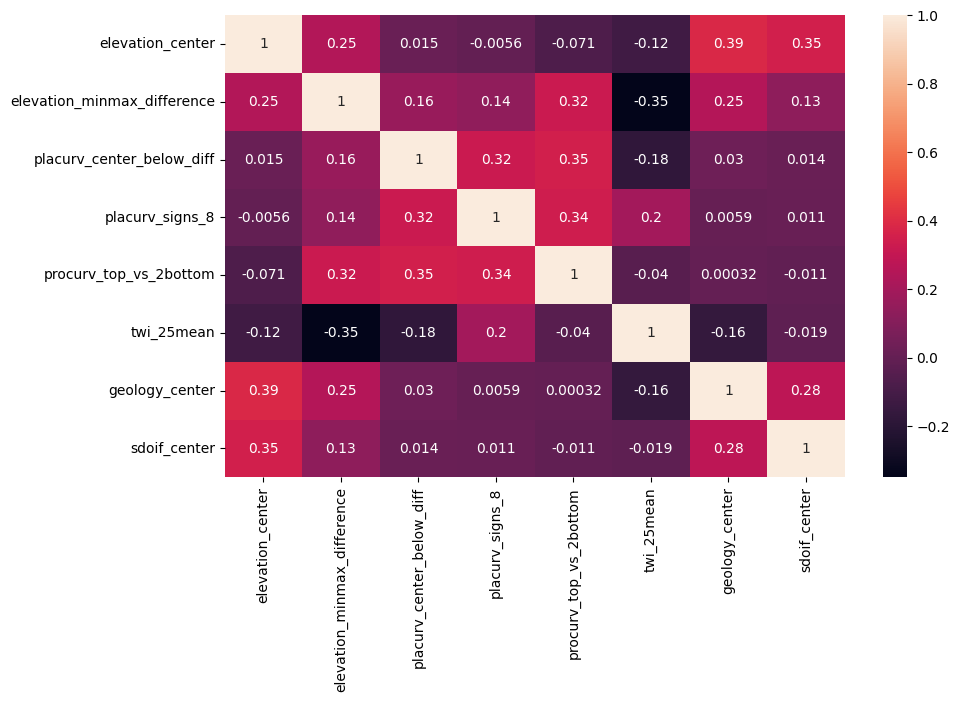

In [481]:
model_lg1_top_features.remove('twi_center')
model_lg1_top_features.remove('lsfactor_sum_center_1below')
plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled[model_lg1_top_features].corr(), annot=True)

### Fit model

In [437]:
# function for fitting the data and display confusion matrix in one line
def build_lg(features, threshold=0.5, cf=True, score=True):
    '''
    features: list like, excluding const
    '''
    logres = sm.GLM(y_train, X_train_scaled[['const'] + features], family = sm.families.Binomial())
    model = logres.fit()
    print(model.summary())
    
    yhat_train = model.predict(X_train_scaled[['const'] + features])
    yhat_train = yhat_train.apply(lambda x: 1 if x>threshold else 0)
    yhat_test = model.predict(X_test_scaled[['const'] + features])
    yhat_test = yhat_test.apply(lambda x: 1 if x>threshold else 0)
    
    if cf:
        cf_train_test(y_train, yhat_train, y_test, yhat_test)
    if score:
        print('Train')
        print(classification_report(y_train, yhat_train))
        print('Test')
        print(classification_report(y_test, yhat_test))
    return model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9768
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4296.1
Date:                Sun, 16 Apr 2023   Deviance:                       8592.2
Time:                        19:00:55   Pearson chi2:                 9.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2179
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

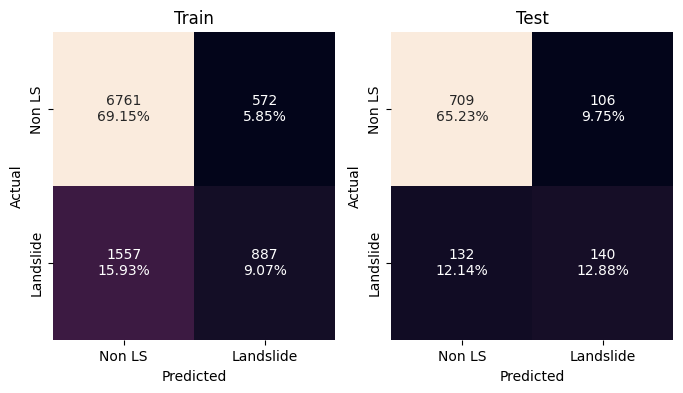

Train
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      7333
           1       0.61      0.36      0.45      2444

    accuracy                           0.78      9777
   macro avg       0.71      0.64      0.66      9777
weighted avg       0.76      0.78      0.76      9777

Test
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       815
           1       0.57      0.51      0.54       272

    accuracy                           0.78      1087
   macro avg       0.71      0.69      0.70      1087
weighted avg       0.77      0.78      0.78      1087



In [482]:
model_lg1 = build_lg(model_lg1_top_features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9769
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4296.7
Date:                Sun, 16 Apr 2023   Deviance:                       8593.4
Time:                        19:01:03   Pearson chi2:                 9.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2178
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

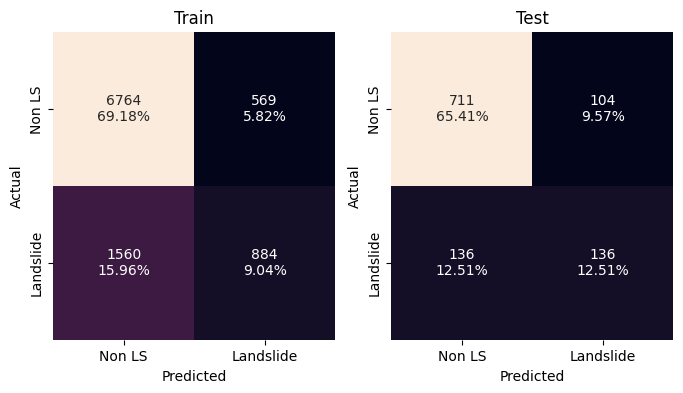

Train
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      7333
           1       0.61      0.36      0.45      2444

    accuracy                           0.78      9777
   macro avg       0.71      0.64      0.66      9777
weighted avg       0.76      0.78      0.76      9777

Test
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       815
           1       0.57      0.50      0.53       272

    accuracy                           0.78      1087
   macro avg       0.70      0.69      0.69      1087
weighted avg       0.77      0.78      0.77      1087



In [483]:
model_lg1_top_features.remove('procurv_top_vs_2bottom')
model_lg1 = build_lg(model_lg1_top_features)

In [445]:
# function to plot precision/recall curve
def pre_rec_curve(model, features, threshold=0.5):
    X_data = X_train_scaled[['const']+features]

    y_scores=model.predict(X_data)

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    thresholds = np.insert(thresholds, 0, 0)
    F1_score = 2*precisions*recalls/(precisions+recalls)


    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize=(10,7))
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.plot(thresholds, F1_score, 'r--', label = 'f1 score')

    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0.4,1])
    plt.axvline(threshold)
    plt.show()

C:\Users\nguye_5159g\AppData\Local\Temp\ipykernel_14012\752658623.py:9: RuntimeWarning: invalid value encountered in true_divide
  F1_score = 2*precisions*recalls/(precisions+recalls)


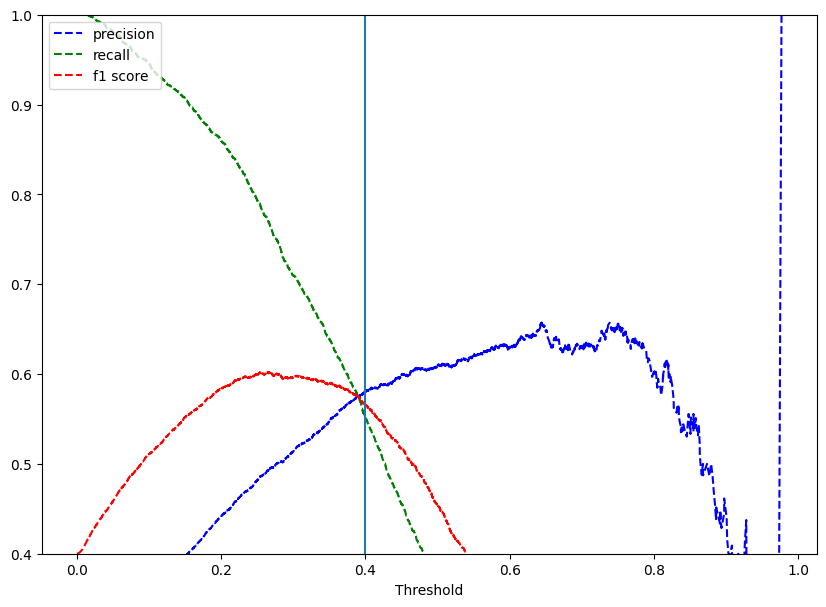

In [484]:
pre_rec_curve(model_lg1, model_lg1_top_features, threshold=0.4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9769
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4296.7
Date:                Sun, 16 Apr 2023   Deviance:                       8593.4
Time:                        19:01:53   Pearson chi2:                 9.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2178
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

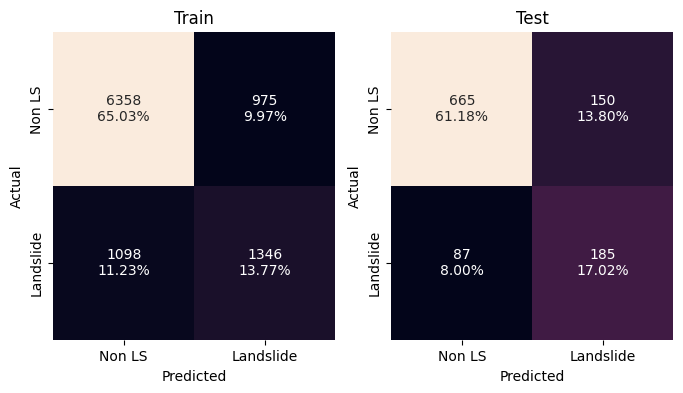

Train
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7333
           1       0.58      0.55      0.56      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.71      0.71      9777
weighted avg       0.78      0.79      0.79      9777

Test
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       815
           1       0.55      0.68      0.61       272

    accuracy                           0.78      1087
   macro avg       0.72      0.75      0.73      1087
weighted avg       0.80      0.78      0.79      1087



In [485]:
model_lg1 = build_lg(model_lg1_top_features, threshold=0.4)

## Building model 2

### Feature selection

In [486]:
X_train_scaled

,const,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center,aspect_N,aspect_NE,aspect_NW,aspect_S,aspect_SE,aspect_SW,aspect_W
6613,1.0000,0.0576,0.1224,0.2543,0.1776,0.8959,0.3432,0.4438,0.7752,0.3266,0.8122,0.4797,0.0001,0.3953,0.8625,1.0000,0.3333,0.7320,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4788,1.0000,0.1375,0.3061,0.3878,0.0856,0.2132,0.0373,0.4965,0.7938,0.4533,1.0000,0.5328,0.2456,0.1474,0.1613,1.0000,1.0000,0.7986,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
4863,1.0000,0.0898,0.2449,0.3878,0.0590,0.1244,0.0359,0.4795,0.2846,0.3404,0.7997,0.5101,0.1638,0.1317,0.1624,1.0000,0.3333,0.6638,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
5864,1.0000,0.0776,0.1020,0.1737,0.1224,0.2573,0.0635,0.4607,0.2846,0.2901,0.2316,0.4394,0.0857,0.2106,0.1575,0.5000,0.6667,0.4994,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5693,1.0000,0.5288,0.1837,0.2906,0.0462,0.0579,0.0335,0.4651,1.0000,0.3425,0.2316,0.4892,0.1797,0.1642,0.2059,1.0000,0.3333,0.8589,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1.0000,0.2151,0.2449,0.2543,0.2131,0.8230,0.2766,0.3830,0.7938,0.3135,0.8122,0.4985,0.2701,0.3469,0.3584,0.0000,0.0000,0.6597,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3755,1.0000,0.4213,0.2449,0.4671,0.0696,0.3291,0.0459,0.5830,1.0000,0.4352,1.0000,0.5883,0.1748,0.0526,0.0960,1.0000,0.3333,0.9651,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
9026,1.0000,0.1286,0.2857,0.4671,0.0879,0.1962,0.0406,0.5147,0.7938,0.4058,0.8122,0.6482,0.3104,0.1876,0.1909,1.0000,0.3333,0.7377,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
299,1.0000,0.5055,0.4082,0.6546,0.0230,0.1197,0.0307,0.4138,0.2846,0.1855,0.8122,0.5093,0.3323,0.1114,0.1672,1.0000,0.3333,0.7846,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


In [491]:
for feature in X_train_scaled.columns[1:]:
    print(feature)
    convert_woe(feature)
    print('------------------------')

elevation_center
Information value: 0.28
------------------------
elevation_minmax_difference
Information value: 0.92
------------------------
slope_center
Information value: 1.06
------------------------
slope_difference_pct
Information value: 0.18
------------------------
aspect_span
Information value: 0.09
------------------------
aspect_sum_span_9cells
Information value: 0.05
------------------------
placurv_center_below_diff
Information value: 0.06
------------------------
placurv_signs_8
Information value: 0.13
------------------------
placurv_top_vs_2bottom
Information value: 0.16
------------------------
procurv_signs_8
Information value: 0.11
------------------------
procurv_top_vs_2bottom
Information value: 0.11
------------------------
lsfactor_sum_center_1below
Information value: 0.69
------------------------
twi_center
Information value: 0.24
------------------------
twi_25mean
Information value: 0.40
------------------------
geology_center
Information value: 0.58
--------

In [492]:
model_lg2_features = [
    'elevation_minmax_difference', 
    'slope_center', 
    'aspect_span',
    'placurv_top_vs_2bottom', 
    'procurv_top_vs_2bottom',
    'lsfactor_sum_center_1below',
    'twi_25mean',
    'geology_center', 
    'sdoif_center'
]

### Checking multicollinearity

In [493]:
checking_vif(model_lg2_features)

,feature,VIF
0,const,81.9200
2,slope_center,4.2500
1,elevation_minmax_difference,3.8400
6,lsfactor_sum_center_1below,3.3500
7,twi_25mean,1.6200
4,placurv_top_vs_2bottom,1.4400
5,procurv_top_vs_2bottom,1.3900
3,aspect_span,1.2300
8,geology_center,1.1700
9,sdoif_center,1.1000


<Axes: >

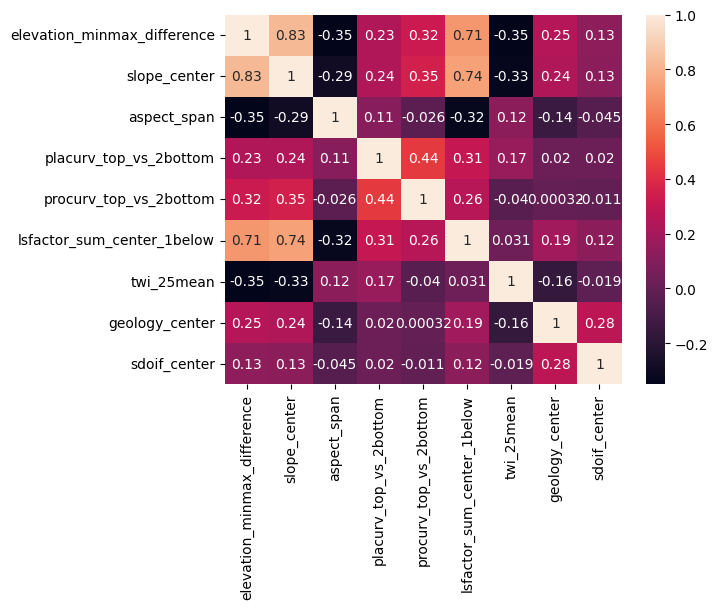

In [494]:
sns.heatmap(X_train_scaled[model_lg2_features].corr(), annot=True)

<Axes: >

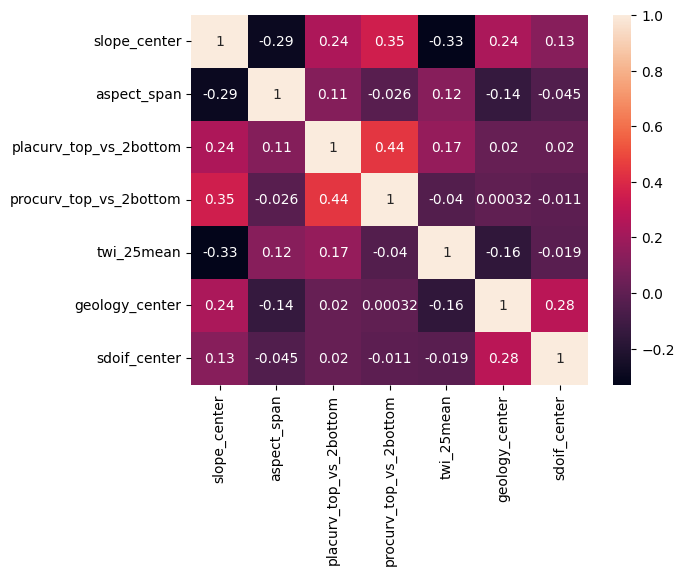

In [495]:
model_lg2_features.remove('elevation_minmax_difference')
model_lg2_features.remove('lsfactor_sum_center_1below')
sns.heatmap(X_train_scaled[model_lg2_features].corr(), annot=True)

### Build model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9769
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4230.0
Date:                Sun, 16 Apr 2023   Deviance:                       8460.0
Time:                        19:09:44   Pearson chi2:                 9.47e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2284
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6

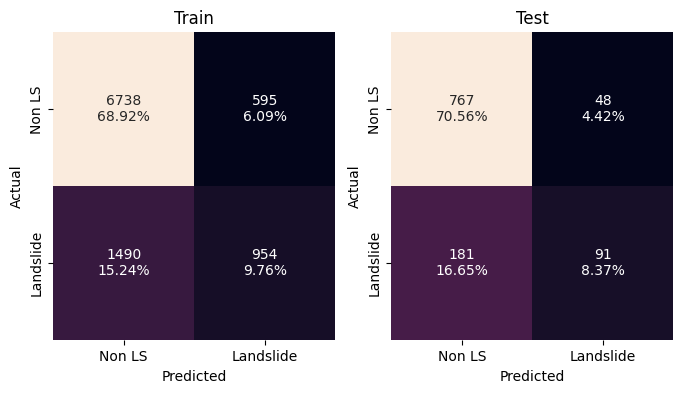

Train
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      7333
           1       0.62      0.39      0.48      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.65      0.67      9777
weighted avg       0.77      0.79      0.77      9777

Test
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       815
           1       0.65      0.33      0.44       272

    accuracy                           0.79      1087
   macro avg       0.73      0.64      0.66      1087
weighted avg       0.77      0.79      0.76      1087



In [496]:
model_lg2 = build_lg(model_lg2_features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9770
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4230.0
Date:                Sun, 16 Apr 2023   Deviance:                       8460.1
Time:                        19:10:05   Pearson chi2:                 9.48e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2284
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6

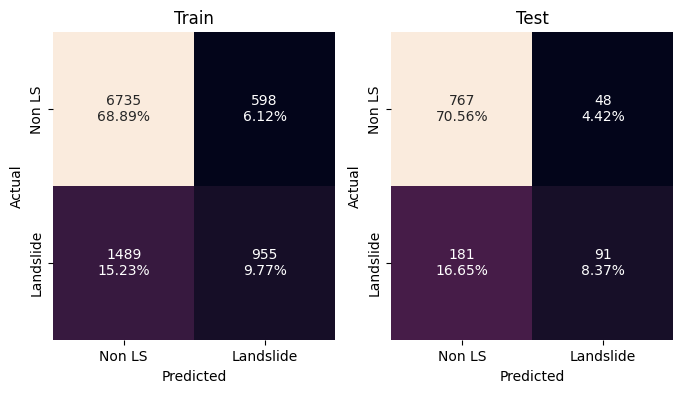

Train
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      7333
           1       0.61      0.39      0.48      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.65      0.67      9777
weighted avg       0.77      0.79      0.77      9777

Test
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       815
           1       0.65      0.33      0.44       272

    accuracy                           0.79      1087
   macro avg       0.73      0.64      0.66      1087
weighted avg       0.77      0.79      0.76      1087



In [497]:
model_lg2_features.remove("aspect_span")
model_lg2 = build_lg(model_lg2_features)

C:\Users\nguye_5159g\AppData\Local\Temp\ipykernel_14012\752658623.py:9: RuntimeWarning: invalid value encountered in true_divide
  F1_score = 2*precisions*recalls/(precisions+recalls)


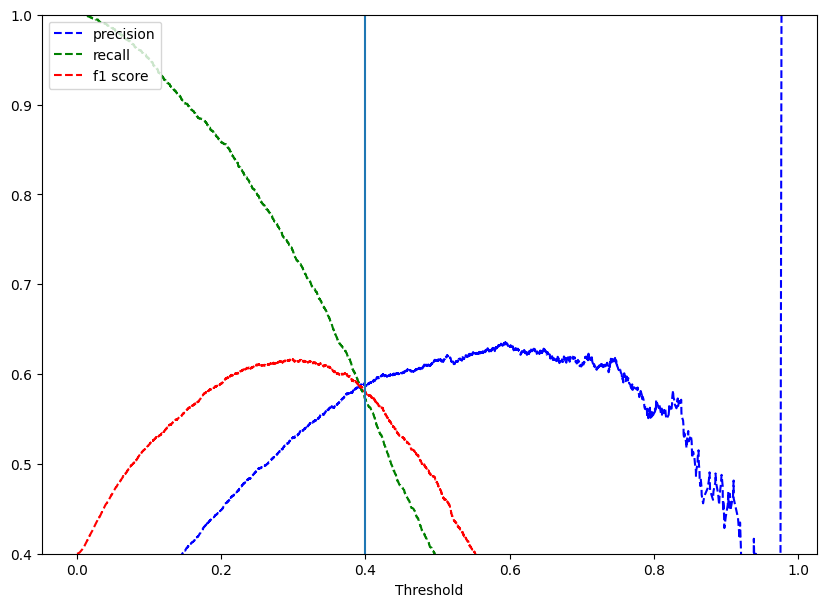

In [498]:
pre_rec_curve(model_lg2, model_lg2_features, threshold=0.4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9770
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4230.0
Date:                Sun, 16 Apr 2023   Deviance:                       8460.1
Time:                        19:10:45   Pearson chi2:                 9.48e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2284
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6

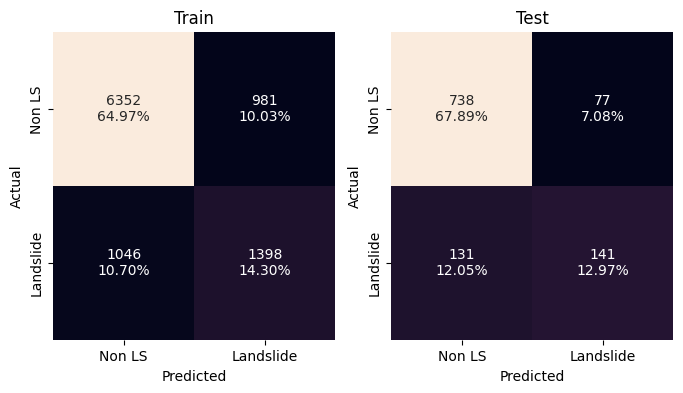

Train
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7333
           1       0.59      0.57      0.58      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.72      0.72      9777
weighted avg       0.79      0.79      0.79      9777

Test
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       815
           1       0.65      0.52      0.58       272

    accuracy                           0.81      1087
   macro avg       0.75      0.71      0.73      1087
weighted avg       0.80      0.81      0.80      1087



In [499]:
model_lg2 = build_lg(model_lg2_features, threshold=0.4)

## Comparing AUC

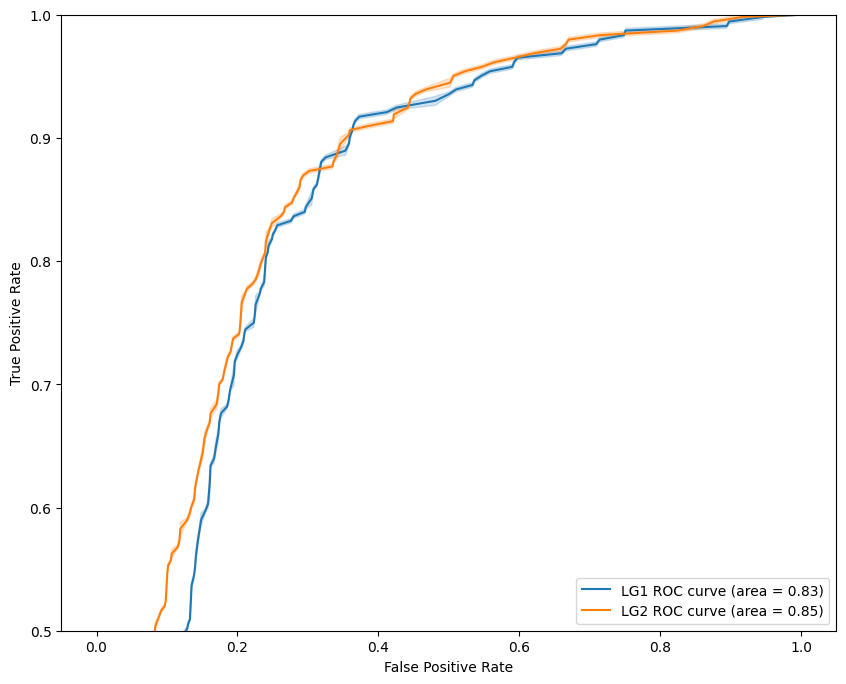

In [512]:
plt.figure(figsize=(10,8))
for model, model_name, feature in [
    (model_lg1, 'LG1', model_lg1_top_features),
    (model_lg2, 'LG2', model_lg2_features)
]:
    yhat_proba = model.predict(X_test_scaled[['const']+feature])
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score( y_test, yhat_proba )
    sns.lineplot(x=fpr,y=tpr, label=model_name + ' ROC curve (area = %0.2f)' % auc_score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.ylim(0.5,1)
plt.show()    

# 6. Random Forest

In [523]:
def tree_model_perf(model, model_name):
    start = time.time()
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test  = model.predict(X_test)
    yhat_proba = model.predict_proba(X_test)[::,1]
    auc_score = metrics.roc_auc_score( y_test, yhat_proba )
    
    time_complete = time.time() - start
    
    print(f'{model_name}:  AUC = {auc_score:.3f}, Time: {time_complete:.2f}')
    print('Train')
    print(classification_report(y_train, yhat_train))
    print('Test')
    print(classification_report(y_test, yhat_test))
    
    
    
    cf_train_test(y_train, yhat_train, y_test, yhat_test)
    print('*'*90)

## Base model

RF_base:  AUC = 0.881, Time: 1.19
Train
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      7333
           1       0.67      0.91      0.77      2444

    accuracy                           0.87      9777
   macro avg       0.82      0.88      0.84      9777
weighted avg       0.89      0.87      0.87      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       815
           1       0.60      0.78      0.68       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.84      0.82      0.82      1087



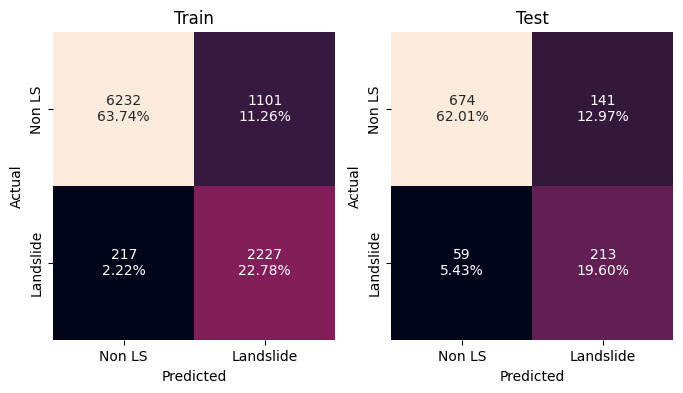

******************************************************************************************


In [524]:
RF_base = RandomForestClassifier(max_depth=10,min_samples_split=10, min_samples_leaf=3, class_weight= class_weights,  random_state = 14)
tree_model_perf(RF_base, 'RF_base')

## Hyper parameter tuning 2 (class weight)

### 1

In [558]:
%%time
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 1.08 s
Wall time: 4.32 s


{'max_depth': 10, 'n_estimators': 100}

RF_tuned1:  AUC = 0.883, Time: 1.27
Train
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7333
           1       0.69      0.95      0.80      2444

    accuracy                           0.88      9777
   macro avg       0.83      0.90      0.86      9777
weighted avg       0.91      0.88      0.89      9777

Test
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       815
           1       0.61      0.79      0.69       272

    accuracy                           0.82      1087
   macro avg       0.77      0.81      0.78      1087
weighted avg       0.84      0.82      0.83      1087



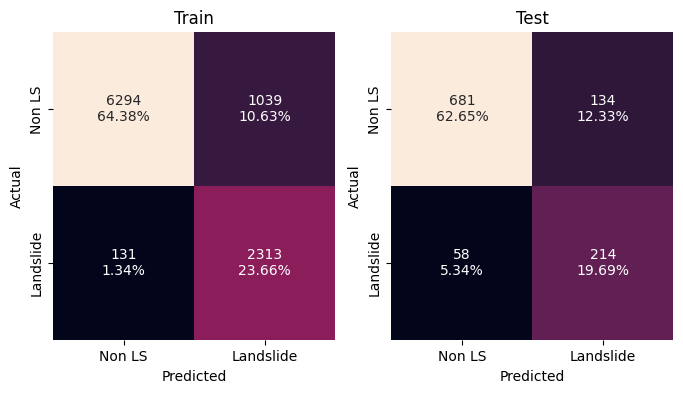

******************************************************************************************


In [559]:
RF_tuned1 = grid_search.best_estimator_
tree_model_perf(RF_tuned1, 'RF_tuned1')

### 2

In [563]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    # 'n_estimators': [50, 100],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 922 ms
Wall time: 5.14 s


{'max_depth': 9}

RF_tuned2:  AUC = 0.881, Time: 1.14
Train
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      7333
           1       0.65      0.92      0.76      2444

    accuracy                           0.85      9777
   macro avg       0.81      0.88      0.83      9777
weighted avg       0.89      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.77      0.81      0.78      1087
weighted avg       0.85      0.82      0.83      1087



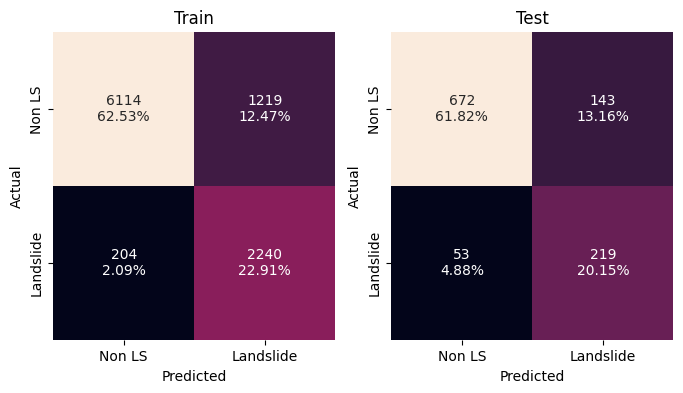

******************************************************************************************


In [564]:
RF_tuned2 = grid_search.best_estimator_
tree_model_perf(RF_tuned2, 'RF_tuned2')

### 3

We now have a quite comparable performance between train and test set.

Adjusting min samples in leaf and split

In [565]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    # 'n_estimators': [80, 100, 150, 200],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 2.89 s
Wall time: 36.1 s


{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7}

RF_tuned3:  AUC = 0.881, Time: 1.12
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



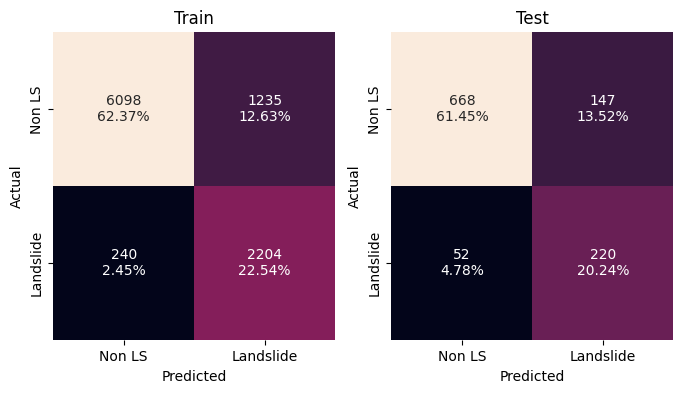

******************************************************************************************


In [566]:
RF_tuned3 = grid_search.best_estimator_
tree_model_perf(RF_tuned3, 'RF_tuned3')

### 4

Increase ms split parameter

In [567]:
%%time
param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 7, 8, 9],
    # 'n_estimators': [80, 100, 150, 200],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 3.05 s
Wall time: 46.5 s


{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7}

RF_tuned4:  AUC = 0.881, Time: 1.14
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



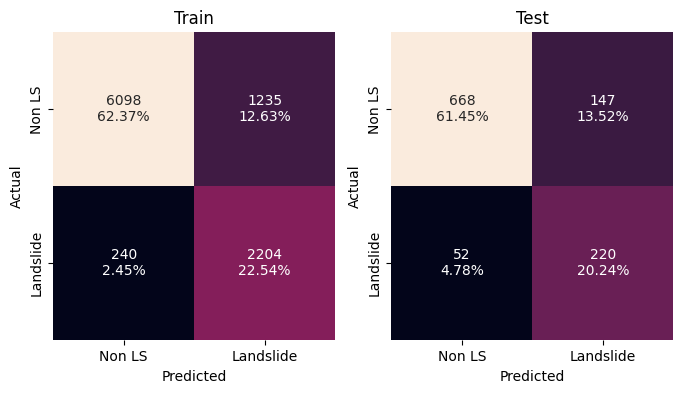

******************************************************************************************


In [568]:
RF_tuned4 = grid_search.best_estimator_
tree_model_perf(RF_tuned4, 'RF_tuned4')

### 5

No change. Add n_estimators

In [569]:
%%time
param_grid = {
    'max_depth': [8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 7, 8],
    'n_estimators': [80, 100, 150, 200],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 3.75 s
Wall time: 1min 26s


{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 80}

RF_tuned5:  AUC = 0.880, Time: 0.94
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



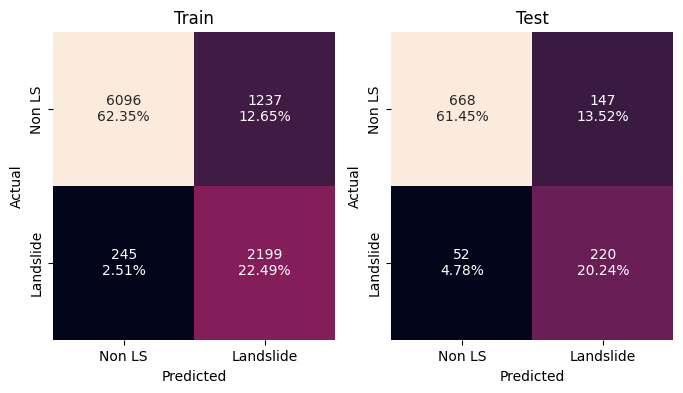

******************************************************************************************


In [570]:
RF_tuned5 = grid_search.best_estimator_
tree_model_perf(RF_tuned5, 'RF_tuned5')

### 6

Lower n_estimator further

In [572]:
%%time
param_grid = {
    'max_depth': [8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 7, 8],
    'n_estimators': [50, 80, 100, 120],
}

rf = RandomForestClassifier(class_weight= class_weights, random_state=14)
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=auc_scorer)
grid_search.fit(X_train, y_train)

grid_search.best_params_

CPU times: total: 3.88 s
Wall time: 56.2 s


{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 80}

RF_tuned6:  AUC = 0.880, Time: 0.94
Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7333
           1       0.64      0.90      0.75      2444

    accuracy                           0.85      9777
   macro avg       0.80      0.87      0.82      9777
weighted avg       0.88      0.85      0.86      9777

Test
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       815
           1       0.60      0.81      0.69       272

    accuracy                           0.82      1087
   macro avg       0.76      0.81      0.78      1087
weighted avg       0.85      0.82      0.82      1087



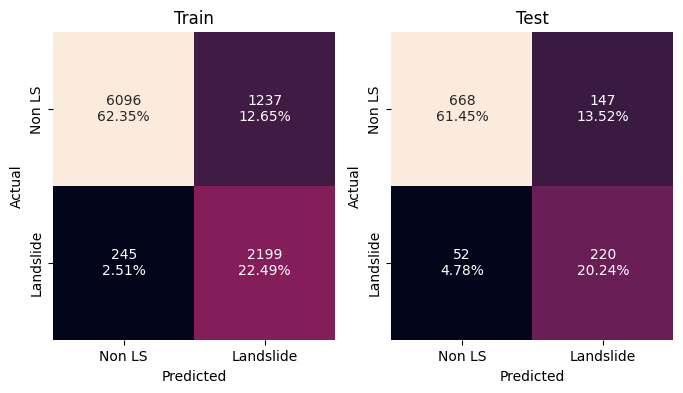

******************************************************************************************


In [573]:
RF_tuned6 = grid_search.best_estimator_
tree_model_perf(RF_tuned6, 'RF_tuned6')

## Comparing AUC

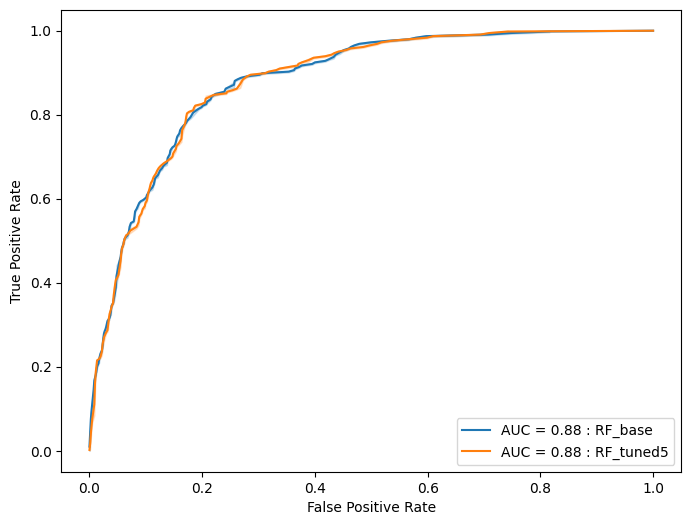

In [571]:
plt.figure(figsize=(8,6))

for model, model_name in [
    (RF_base, 'RF_base'),
    (RF_tuned5, 'RF_tuned5')
]:
    yhat_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score(y_test,  yhat_proba)
    space = ' ' * (20 - len(model_name))
    sns.lineplot(x=fpr,y=tpr, label=f'AUC = {auc_score:0.2f} : {model_name}')
    
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()    